In [1]:
import pandas as pd
import numpy as np

In [2]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')
train_df['AlogP'] = np.where(pd.isna(train_df['AlogP']), train_df['LogD'], train_df['AlogP'])
test_df['AlogP'] = np.where(pd.isna(test_df['AlogP']), test_df['LogD'], test_df['AlogP'])

In [3]:
from rdkit.Chem import Descriptors
def getMolDescriptors(mol, missingVal=None):
    res = {}
    for nm,fn in Descriptors._descList:
        # some of the descriptor fucntions can throw errors if they fail, catch those here:
        try:
            val = fn(mol)
        except:
            # print the error message:
            import traceback
            traceback.print_exc()
            # and set the descriptor value to whatever missingVal is
            val = missingVal
        res[nm] = val
    return res

In [4]:
from rdkit import Chem
train_df['Molecule'] = train_df['SMILES'].apply(Chem.MolFromSmiles)
test_df['Molecule'] = test_df['SMILES'].apply(Chem.MolFromSmiles)

In [5]:
train_desc = [getMolDescriptors(m) for m in train_df['Molecule']]
test_desc = [getMolDescriptors(m) for m in test_df['Molecule']]
train_desc = pd.DataFrame(train_desc)
test_desc = pd.DataFrame(test_desc)

In [6]:
train_desc = pd.concat([train_df,train_desc],axis = 1)
test_desc = pd.concat([test_df,test_desc],axis = 1)

In [7]:
train_desc = train_desc.drop_duplicates(['SMILES'], keep=False).reset_index(drop=True)

In [8]:
col_list = train_desc.columns
drop_list = []
for col in col_list:
  missing = train_desc[col].isna().any()
  if missing == True:
    drop_list.append(col)
train_desc = train_desc.drop(drop_list, axis=1)
test_desc = test_desc.drop(drop_list, axis=1)

In [9]:
from rdkit.Chem import MACCSkeys

def toMACCKeys(mol):
    maccs = MACCSkeys.GenMACCSKeys(mol)
    bits = [int(bit) for bit in maccs.ToBitString()]

    return bits

In [10]:
train_fps = pd.DataFrame(train_desc["Molecule"].apply(toMACCKeys))
test_fps =  pd.DataFrame(test_desc["Molecule"].apply(toMACCKeys))


In [11]:
train_fps = pd.DataFrame(train_fps["Molecule"].tolist(), columns=[f"fp{i}" for i in range(len(train_fps["Molecule"][0]))])
test_fps = pd.DataFrame(test_fps["Molecule"].tolist(), columns=[f"fp{i}" for i in range(len(test_fps["Molecule"][0]))])

In [12]:
train_desc = pd.concat([train_desc, train_fps], axis=1)
test_desc = pd.concat([test_desc, test_fps], axis=1)

In [13]:
train_desc.head()

,id,SMILES,MLM,HLM,AlogP,Molecular_Weight,Num_H_Acceptors,Num_H_Donors,Num_RotatableBonds,LogD,...,fp157,fp158,fp159,fp160,fp161,fp162,fp163,fp164,fp165,fp166
0,TRAIN_0000,CCOc1ccc(CNC(=O)c2cc(-c3sc(C)nc3C)n[nH]2)cc1OCC,26.010,50.680,3.259,400.495,5,2,8,3.259,...,1,1,1,1,1,1,1,1,1,0
1,TRAIN_0001,Cc1nc(C)c(CN2CC(C)C(=O)Nc3ccccc32)s1,29.270,50.590,2.169,301.407,2,1,2,2.172,...,0,1,0,1,1,1,1,1,1,0
2,TRAIN_0002,CCCN1CCN(c2nn3nnnc3c3ccccc23)CC1,5.586,80.892,1.593,297.358,5,0,3,1.585,...,0,1,0,1,1,1,1,0,1,0
3,TRAIN_0003,Cc1ccc(-c2ccc(-n3nc(C)c(S(=O)(=O)N4CCN(C5CCCCC...,5.710,2.000,4.771,494.652,6,0,5,3.475,...,0,1,1,1,1,1,1,1,1,0
4,TRAIN_0004,Cc1ccc2c(c1)N(C(=O)c1ccncc1)CC(C)O2,93.270,99.990,2.335,268.310,3,0,1,2.337,...,1,1,1,1,1,1,1,1,1,0


In [14]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [15]:
drop_col_list = ['id','SMILES','MLM','HLM','Molecule']
target_mlm = train_desc['MLM']
target_hlm = train_desc['HLM']

In [16]:
train = train_desc.drop(drop_col_list,axis=1)
test = test_desc.drop(['id','SMILES','Molecule'], axis=1)

In [17]:
feature = [col for col in train.columns if col not in drop_col_list]

In [18]:
train[feature] = scaler.fit_transform(train[feature])
test[feature] = scaler.transform(test[feature])

In [19]:
train_MLM = pd.concat([train, target_mlm], axis=1)
train_HLM = pd.concat([train, target_hlm], axis=1)

In [20]:
from autogluon.tabular import TabularDataset, TabularPredictor
from IPython.display import Image, display

In [21]:
predictor_MLM = TabularPredictor(label='MLM', eval_metric='root_mean_squared_error', verbosity=False).fit(train_MLM)
predictor_HLM = TabularPredictor(label='HLM', eval_metric='root_mean_squared_error', verbosity=False).fit(train_HLM)

ld_board_MLM = predictor_MLM.leaderboard(train_MLM, silent=True)
print("="*20, "MLM", "="*20)
print(ld_board_MLM)
print(f"Best: {predictor_MLM.get_model_best()}")

ld_board_HLM = predictor_HLM.leaderboard(train_HLM, silent=True)
print("="*20, "HLM", "="*20)
print(ld_board_HLM)
print(f"Best: {predictor_HLM.get_model_best()}")

==================== MLM ====================
                  model  score_test  score_val  pred_time_test  pred_time_val  \
0         LightGBMLarge  -11.509393 -29.906275        0.154319       0.017232   
1        KNeighborsDist  -12.618216 -33.116507        0.087658       0.048958   
2       RandomForestMSE  -15.555089 -30.015302        0.197016       0.045719   
3         ExtraTreesMSE  -15.561016 -30.340948        0.185550       0.061762   
4   WeightedEnsemble_L2  -16.686487 -29.475483        0.414232       0.107399   
5               XGBoost  -17.525068 -30.098167        0.063675       0.013552   
6              CatBoost  -19.429132 -29.699504        0.028117       0.008732   
7              LightGBM  -22.053507 -29.747932        0.028653       0.009712   
8            LightGBMXT  -22.398921 -29.920545        0.044567       0.008535   
9        KNeighborsUnif  -28.682439 -33.197591        0.089359       0.067034   
10      NeuralNetFastAI  -29.715624 -32.139565        0.089952 

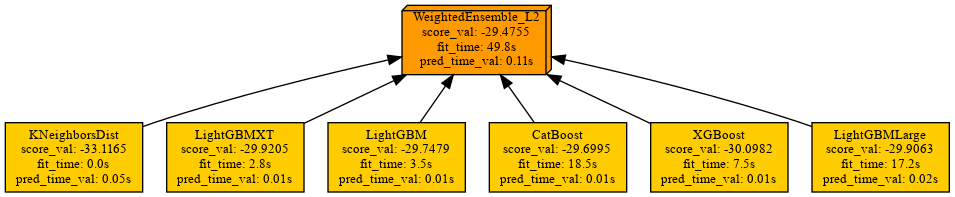

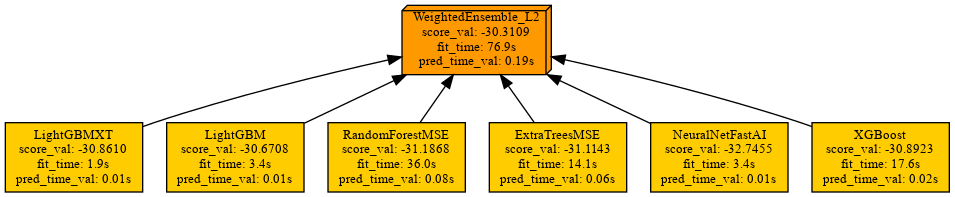

In [22]:
path_to_png=predictor_MLM.plot_ensemble_model()
display(Image(filename=path_to_png))
path_to_png=predictor_HLM.plot_ensemble_model()
display(Image(filename=path_to_png))

In [23]:
# 결과파일 작성
pred_MLM = predictor_MLM.predict(test)
pred_HLM = predictor_HLM.predict(test)

submission = pd.DataFrame()
submission["id"] = test_df["id"]
submission["MLM"] = pred_MLM
submission["HLM"] = pred_HLM

submission.to_csv("../output/submission.csv", index=False)

In [24]:
submission

,id,MLM,HLM
0,TEST_000,35.109707,55.458595
1,TEST_001,62.755409,78.131699
2,TEST_002,32.409981,51.351883
3,TEST_003,49.007805,72.901367
4,TEST_004,66.780151,73.831650
...,...,...,...
478,TEST_478,17.590660,46.155415
479,TEST_479,66.138695,76.614990
480,TEST_480,52.756939,69.760910
481,TEST_481,59.686226,75.082214
